# Covid19 Visualization - Pipeline

### Last Updated: 03-20-2021

First, let's import some libraries

In [245]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

%matplotlib notebook

We would like to load some Covid-19 historical data about Infected, Dead and Recovered cases in df DataFrame, using Panda' read_csv, then process some data cleaning techniques to get needed data for Vietnam only.

In [246]:
df = pd.read_csv('covid_19_data.csv')

df = df[df['Country/Region'] == 'Vietnam']

df = df.drop(['Province/State', 'Country/Region', 'Last Update', 'SNo'], axis = 1).set_index('ObservationDate')

df.index = pd.to_datetime(df.index)

df['Treating'] = df['Confirmed'] - df['Deaths'] - df['Recovered']

In [247]:
# Worse version of animation

# fig = plt.figure(figsize = (10, 5))
# ax = plt.axes(xlim = (df.index[0],df.index[-1]), ylim = (0, df['Treating'].max()))
# plt.show()

# for i, row in df.iterrows():
#     plt.cla()
#     df.loc[:i+pd.Timedelta(1, unit = 'D')]['Treating'].plot(ax = ax)
#     ax.set_xlim(df.index[0],df.index[-1])
#     ax.set_ylim(0, df['Treating'].max())
#     plt.gcf().canvas.draw()
#     plt.pause(0.01)

### Plot a single line on the interacted window.

<IPython.core.display.Javascript object>


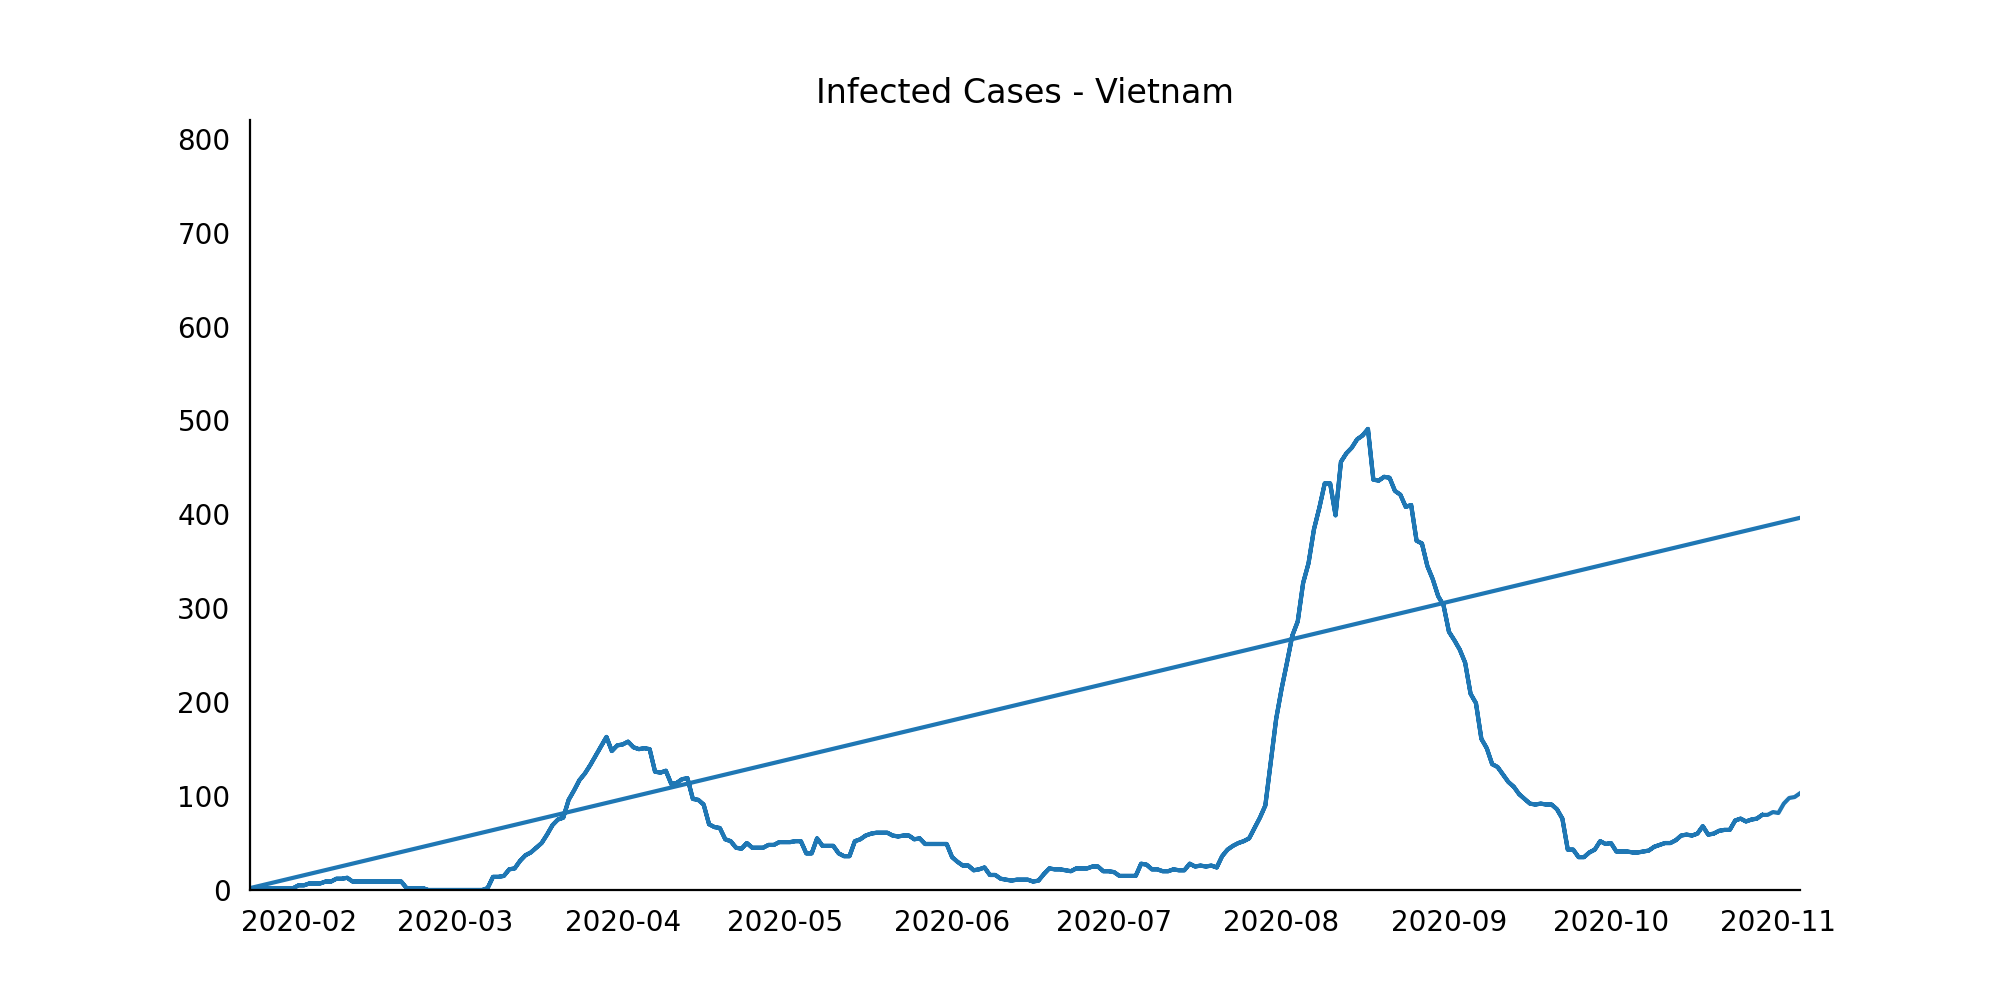

In [268]:
fig, ax = plt.subplots(figsize = (10,5))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(bottom = False, left = False)
xdata, ydata = [], []
ln, = plt.plot([], [])
plt.title('Infected Cases - Vietnam')

def init():
    #ax.set_xlim(df.index[0] - pd.Timedelta(1, unit = 'W'),df.index[-1] + pd.Timedelta(1, unit = 'W'))
    #ax.set_ylim(0, df['Treating'].max() + 100.)
    return ln,

def update(frame):
    xdata.append(frame)
    ydata.append(df.loc[frame]['Treating'])
    ax.set_xlim(df.index[0], frame + pd.Timedelta(1, unit = 'W'))
    ax.set_ylim(0, max(ydata) + 100)
    ln.set_data(xdata, ydata)
    return ln,

ani = FuncAnimation(fig, update, frames = df.index, init_func = init, blit = True, interval = 100, repeat = False,
                   save_count=sys.maxsize)

writergif = PillowWriter(fps=60) 
ani.save('oneline.gif', writer = writergif)

In the same dataset above, we will load the data of US and Mainland China, then clean and merge them in a single dataframe.

In [218]:
df = pd.read_csv('covid_19_data.csv')

df = df.drop(['Province/State', 'Last Update', 'SNo'], axis = 1)
df['ObservationDate'] = pd.to_datetime(df['ObservationDate'])

us = df[df['Country/Region'] == 'US'].groupby('ObservationDate', sort = False).sum().drop(['Confirmed', 'Recovered'], axis = 1)
cn = df[df['Country/Region'] == 'Mainland China'].groupby('ObservationDate', sort = False).sum().drop(['Confirmed', 'Recovered'], axis = 1)

In [219]:
df_merge = pd.merge(us, cn, how = 'outer', on = 'ObservationDate', suffixes = ['_us', '_cn'])

df_merge

,Deaths_us,Deaths_cn
ObservationDate,,
2020-01-22,0.0,17.0
2020-01-23,0.0,34.0
2020-01-24,0.0,26.0
2020-01-25,0.0,42.0
2020-01-26,0.0,56.0
...,...,...
2021-02-23,502660.0,4636.0
2021-02-24,505890.0,4636.0
2021-02-25,508307.0,4636.0


### Plot two lines on the interactive window.

<IPython.core.display.Javascript object>


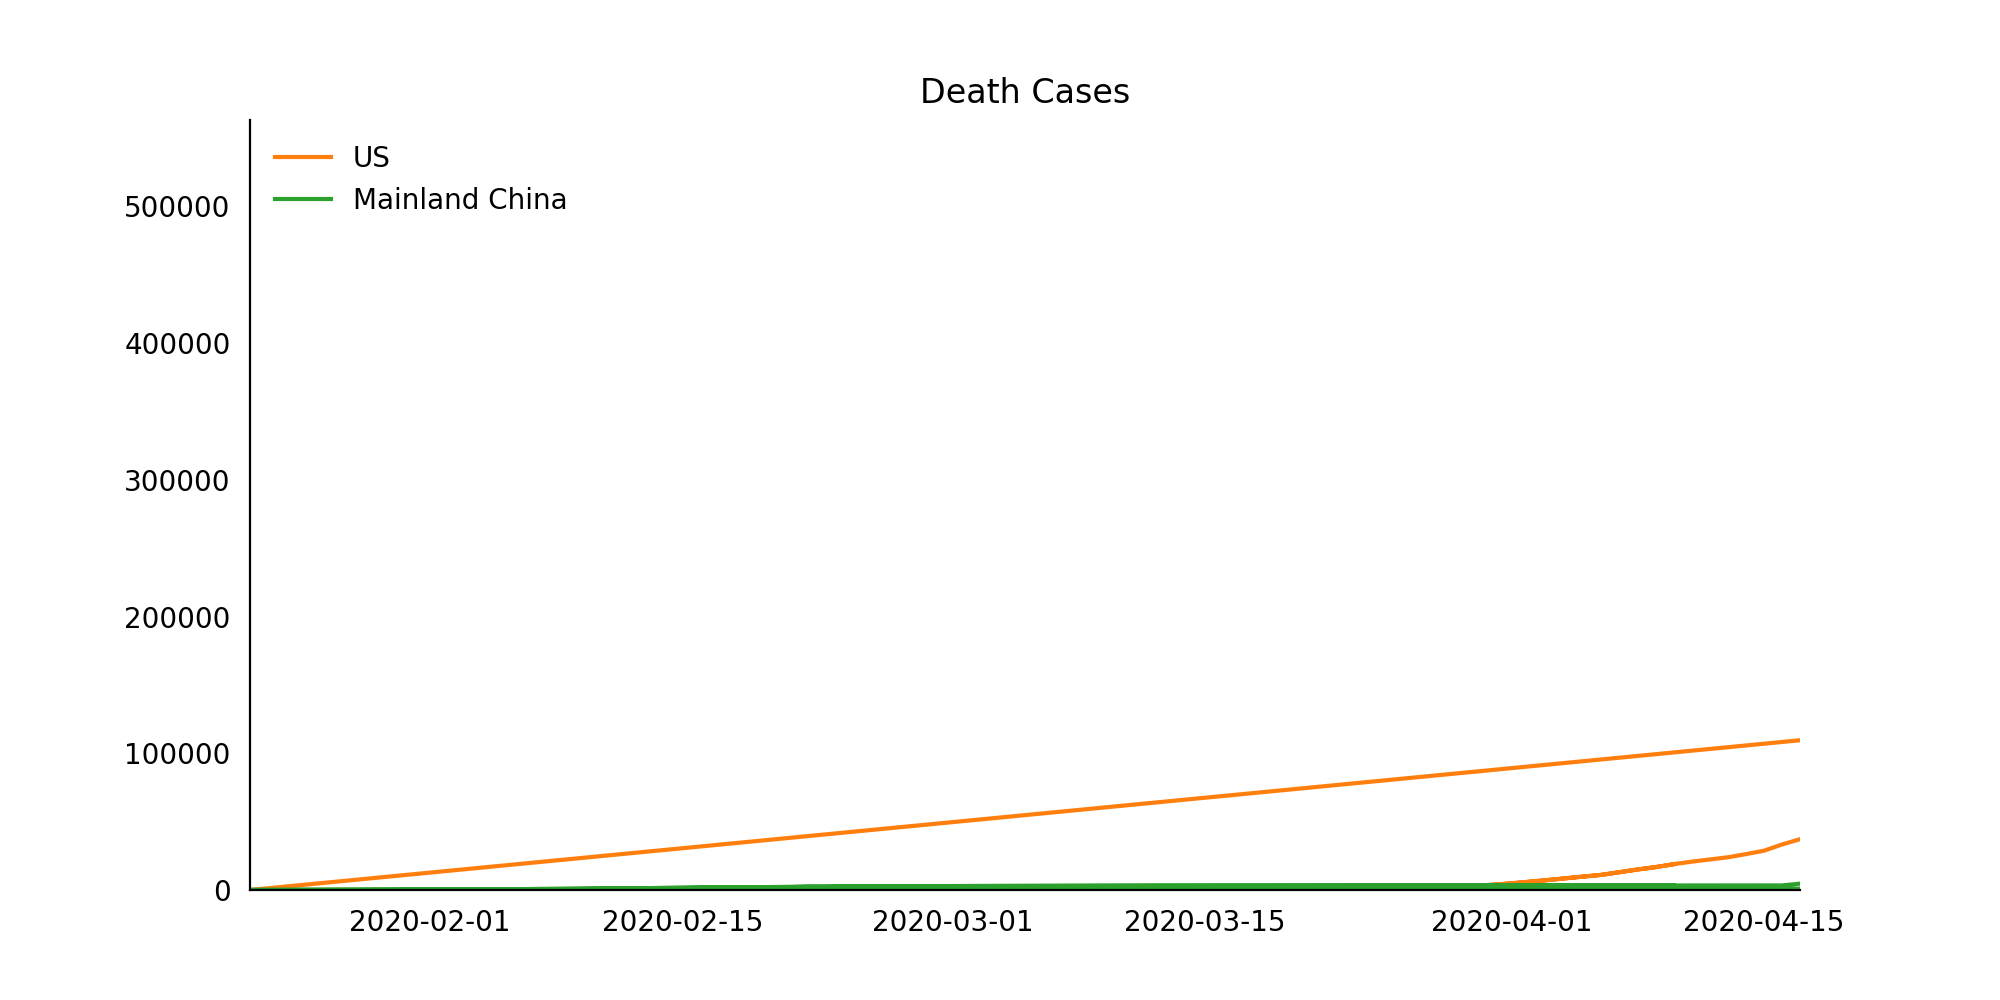

In [270]:
fig, ax = plt.subplots(figsize = (10,5))
plt.title('Death Cases')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(bottom = False, left = False)
ax.set_xlim(df_merge.index[0] - pd.Timedelta(1, unit = 'W'),df_merge.index[-1] + pd.Timedelta(1, unit = 'W'))
ax.set_ylim(0, max(df_merge['Deaths_us'].max(), df_merge['Deaths_cn'].max()))
x1, y1, x2, y2 = [], [], [], []
line, = ax.plot([], [])
lines = []
label = ['US', 'Mainland China']
for idx in range(2):
    l = ax.plot([], [], label = label[idx])[0]
    lines.append(l)
    ax.legend(loc=2, frameon = False)

def init():
    for line in lines:
        line.set_data([],[])
    return lines

def update(frame):
    x1.append(frame)
    x2.append(frame)
    y1.append(df_merge.loc[frame]['Deaths_us'])
    y2.append(df_merge.loc[frame]['Deaths_cn'])
    ax.set_xlim(df_merge.index[0], frame + pd.Timedelta(1, unit = 'W'))
    ax.set_ylim(0., max(max(y1), max(y2))*1.1)
    lines[0].set_data(x1, y1)
    lines[1].set_data(x2, y2)
    return lines

ani = FuncAnimation(fig, update, frames = df_merge.index, init_func = init, blit = True, interval = 50, repeat = False, save_count = sys.maxsize)

writergif = PillowWriter(fps=60) 
ani.save('twolines.gif', writer = writergif)

So far, we only plot one, and then two lines on the same interactive windows. Now we want to plot ten countries whose most death cases, from the very beginning to the last day that the dataset have been updated.

In [286]:
df = pd.read_csv('covid_19_data.csv')

df = df.drop(['Province/State', 'Last Update', 'SNo'], axis = 1)
df['ObservationDate'] = pd.to_datetime(df['ObservationDate'])

t_df = df.groupby(['ObservationDate','Country/Region'], sort = False).sum().drop(['Confirmed', 'Recovered'], axis = 1)

top10 = t_df.loc[(t_df.index.get_level_values('ObservationDate') == '2021-02-27')].nlargest(columns = 'Deaths',n = 10).index.get_level_values('Country/Region')

top10 = df[df['Country/Region'].isin(top10.values)]

top10 = top10.drop(['Confirmed', 'Recovered'], axis = 1)

top10 = top10.groupby(['ObservationDate', 'Country/Region']).agg({'Deaths': sum}).unstack()

top10 = top10.fillna(0)

top10 = top10.sort_values(by = top10.index[-1], ascending = False, axis = 1)

### Plot multiple lines on the interactive windows

<IPython.core.display.Javascript object>


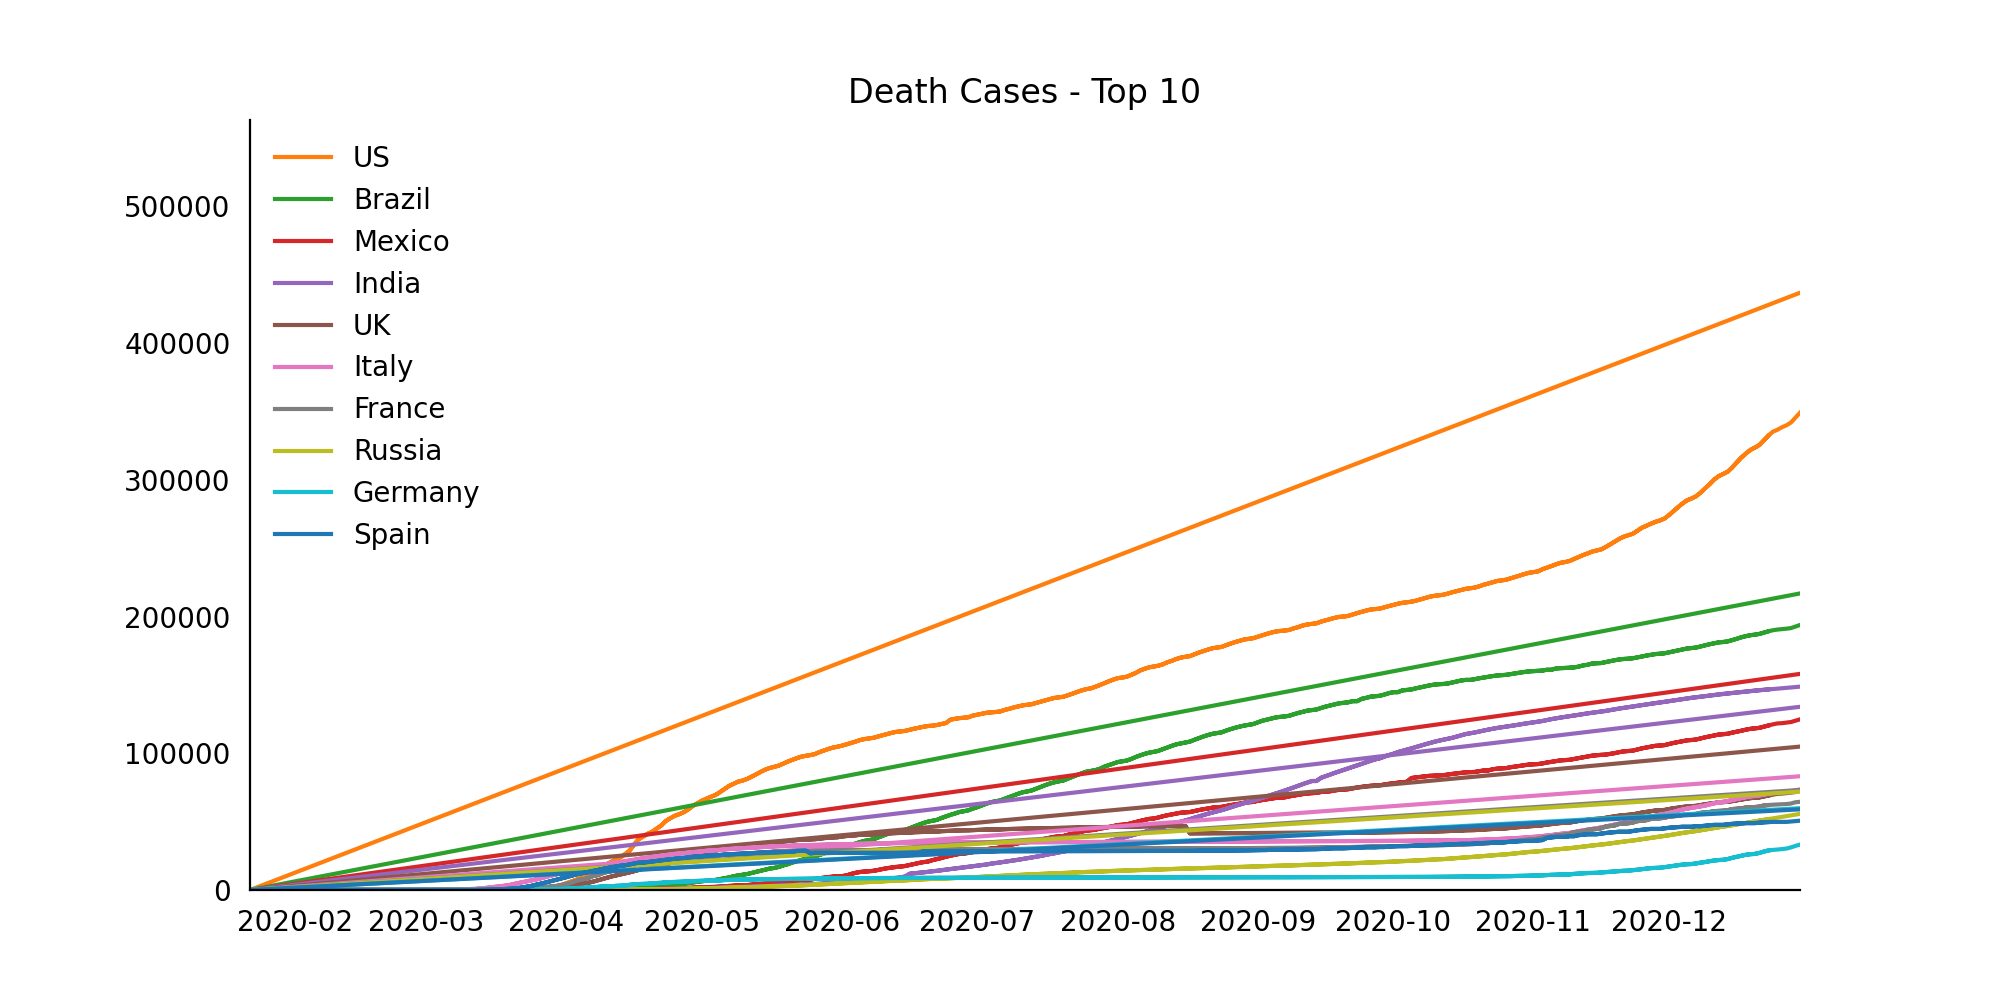

In [287]:
fig, ax = plt.subplots(figsize = (10,5))
plt.title('Death Cases - Top 10')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(bottom = False, left = False)
ax.set_xlim(top10.index[0] - pd.Timedelta(1, unit = 'W'),top10.index[-1] + pd.Timedelta(1, unit = 'W'))
ax.set_ylim(0, 500000)
xdata = []
ydata = [[] for _ in range(len(top10.columns))]
line, = ax.plot([], [])
lines = []
for _, colname in enumerate(list(zip(*top10.columns))[1]):
    l = ax.plot([], [], label = colname)[0]
    ax.legend(loc=2, frameon = False)
    lines.append(l)
def init():
    for line in lines:
        line.set_data([],[])
    return lines

def update(frame):
    xdata.append(frame)
    for i, y in enumerate(ydata):
        y.append(top10.loc[frame]['Deaths'].iloc[i])
    ax.set_xlim(top10.index[0], frame + pd.Timedelta(1, unit = 'W'))
    ax.set_ylim(0., 10. + max([max(y) for y in ydata])*1.1)
    for i, line in enumerate(lines):
        line.set_data(xdata, ydata[i])
    return lines

ani = FuncAnimation(fig, update, frames = top10.index, init_func = init, blit = True, interval = 50, repeat = False, save_count = sys.maxsize)

writergif = PillowWriter(fps=60) 
ani.save('top10.gif', writer = writergif)